<a href="https://colab.research.google.com/github/dude123studios/AdvancedDeepLearning/blob/main/Speech_Commands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['stop' 'yes' 'go' 'down' 'left' 'no' 'right' 'up']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/2197f41c_nohash_2.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

In [6]:
def decode_audio(audio):
  audio, _ = tf.audio.decode_wav(audio)
  return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(train_files)
dataset = dataset.map(get_waveform_and_label)

Now that we made our own tfds, we have to convert the WAV files to a spectrogram, so that we can use a model similar to AlexNet to classify the sounds. spectrograms are image representations of audio, which makes it easier to deal with 16,000 inputs a second, rather than having to use a atrous convolution

In [10]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [11]:
def get_spectrogram_and_label(audio,label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label==commands)
  return spectrogram, label_id

In [12]:
dataset = dataset.map(get_spectrogram_and_label)

In [13]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(get_spectrogram_and_label)
  return output_ds

train = dataset
val = preprocess_dataset(val_files)
test = preprocess_dataset(test_files)

Define some hyperperameters

In [14]:
BATCH_SIZE = 32
EPOCHS = 20
train = train.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)

In [15]:
train = train.cache()
val = val.cache()

In [16]:

for spectrogram, _ in dataset.take(1):
  input_shape = spectrogram.shape
print(input_shape)

(124, 129, 1)


Define model

In [23]:
def get_model():
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(dataset.map(lambda x, _: x))

  input_ = tf.keras.layers.Input(shape=input_shape)
  x = preprocessing.Resizing(128,128)(input_)
  x = norm_layer(x)

  x = layers.Conv2D(32,(3,3),activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(64,(3,3),activation='relu')(x)
  x = layers.MaxPool2D((2,2))(x)

  x = layers.Conv2D(64,(3,3),activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128,(4,4),activation='relu')(x)
  x = layers.MaxPool2D((2,2))(x)

  x = layers.Conv2D(128,(3,3),activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128,(3,3),activation='relu')(x)
  x = layers.MaxPool2D((2,2))(x)

  x = layers.Flatten()(x)
  x = layers.Dense(256,activation='relu')(x)
  x = layers.Dense(128,activation='relu')(x)
  x = layers.Dense(8,activation='softmax')(x)
  model = models.Model(inputs=input_,outputs=x)
  model.summary()

  model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy',optimizer='adam')
  return model

In [24]:
with tf.device('gpu:0'):
  model = get_model()
  history = model.fit(train,validation_data=val,epochs=EPOCHS)
  model.save('speech_commands.h5')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 124, 129, 1)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0   

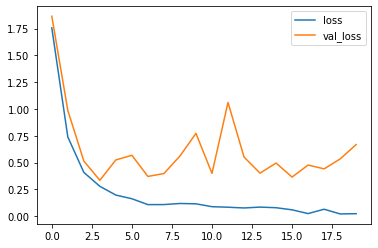

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()